### N-gram language models or how to write scientific papers (4 pts)

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
# !wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
# !tar -xvzf arxivData.json.tar.gz
data = pd.read_json("data/arxivData.json")
data.sample(n=5)

,author,day,id,link,month,summary,tag,title,year
40848,"[{'name': 'Kalyan Nagaraj'}, {'name': 'Amulyas...",19,1502.05534v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,Diagnosis of liver infection at preliminary st...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",NeuroSVM: A Graphical User Interface for Ident...,2015
20489,[{'name': 'Aaron Hunter'}],31,1603.09429v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,We are interested in belief revision involving...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Ordinal Conditional Functions for Nearly Count...,2016
12122,"[{'name': 'Xuanqing Liu'}, {'name': 'Cho-Jui H...",28,1708.08552v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",8,We propose a fast proximal Newton-type algorit...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",An inexact subsampled proximal Newton-type met...,2017
3888,"[{'name': 'Thomas Wiatowski'}, {'name': 'Phili...",10,1707.02711v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",7,Deep convolutional neural networks (CNNs) used...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Topology Reduction in Deep Convolutional Featu...,2017
13141,"[{'name': 'Zhi Li'}, {'name': 'Wei Shi'}, {'na...",25,1704.07807v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,This paper considers the problem of decentrali...,"[{'term': 'math.OC', 'scheme': 'http://arxiv.o...",A decentralized proximal-gradient method with ...,2017


In [3]:
# assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'], axis=1).tolist()

sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Tokenization

You know the dril. The data is messy. Go clean the data. Use WordPunctTokenizer or something.


In [4]:
# Task: convert lines (in-place) into strings of space-separated tokens. import & use WordPunctTokenizer

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
lines = [' '.join(tokenizer.tokenize(line.lower())) for line in lines]

In [5]:
assert sorted(lines, key=len)[0] == \
    'differential contrastive divergence ; this paper has been retracted .'
assert sorted(lines, key=len)[2] == \
    'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .'

### N-Gram Language Model

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that next word only depends on a finite amount of previous words:

$$P(w_{t + 1} \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such model is called __n-gram language model__ where n is a parameter. For example, in 3-gram language model, each word only depends on 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You can also sometimes see such approximation under the name of _n-th order markov assumption_.

The first stage to building such a model is counting all word occurences given N-1 previous words

In [6]:
from tqdm import tqdm
from collections import defaultdict, Counter

# special tokens: 
# - unk represents absent tokens, 
# - eos is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}

    When building counts, please consider the following two edge cases
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    counts = defaultdict(Counter)
    # counts[(word1, word2)][word3] = how many times word3 occured after (word1, word2)

    for line in lines:
        tokens = [UNK] * (n - 1) + line.split() + [EOS]
        for i in range(n - 1, len(tokens)):
            prefix = tuple(tokens[i - n + 1 : i])
            counts[prefix][tokens[i]] += 1
    return counts


In [7]:
# let's test it
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3
assert dummy_counts['p', '=']['np'] == 2
assert dummy_counts['author', '.']['_EOS_'] == 1

Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) } $$

In [8]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w_t | prefix) given ngram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        
        # compute token proabilities given counts
        self.probs = defaultdict(Counter)
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        
        # populate self.probs with actual probabilities
        for prefix, counter in counts.items():
            summ = sum(counter.values())
            self.probs[prefix] = {word: count / summ for word, count in counter.items()}
            
    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : it's probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Let's test it!

In [9]:
dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [13]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add next token by sampling with probabilities.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also try always taking most likely token, sampling among top-K most likely tokens or sampling with temperature. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish.

In [14]:
from numpy.random import choice

def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    pairs = np.array([*lm.get_possible_next_tokens(prefix).items()])
    probs = np.fromiter(map(float, pairs[:, 1]), dtype=np.float)
    if temperature == 0:
        probs = probs == probs.max()
    else:
        probs = probs**(1/temperature)
    return choice(pairs[:, 0], p=probs/probs.sum())

In [15]:
from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200

test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000

print("Looks nice!")

Looks nice!


Let's have fun with this model

In [16]:
prefix = '' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

 r3net : random weights ( as positive candidate pool evaluation for population - based bibliographic information with other factors . because of the mesh and then combined . compared to the other modality via this technique using wikipedia and yago - show the strength of the belief network for image - level analysis yielded a test for computer usage , while the latter excels in expression , illumination , pose and facial expression and character - based intrinsic evaluations are noisy ( e . g ., diaries and email reminders ). however , the number of hidden units in the


In [17]:
prefix = 'bridging the' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

bridging the gap between the two - stream networks and influence diagrams ; we propose a novel two - dimensional data . _EOS_


### Evaluating language models: perplexity

Perplexity is a measure of how well does your model approximate true probability distribution behind data. __Smaller perplexity = better model__.

To compute perplexity on one sentence, use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpora level, perplexity is a product of probabilities of all tokens in all sentences, divided by __total length of all sentences__ in corpora.

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute log-perplexity (from log-probabilities) and then take the exponent.

In [25]:
line = 'asda a sd a sd a sd'

In [29]:
len(line)

19

In [72]:
line[-1: 2]

''

In [127]:
import re

def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    
    N = 0
    summ = 0
    for line in lines:
        spaces = [0] + [space.start() for space in re.finditer(' ', line)] + [len(line)]
        N += len(spaces)
        for i in range(1, len(spaces)):
            begin = spaces[max(0, i - lm.n)]
            middle = spaces[i - 1]
            end = spaces[i]
            summ += max(min_logprob, np.log(lm.get_next_token_prob(line[begin + (begin > 0): middle], line[middle+(middle > 0): end])))
        summ += max(min_logprob, np.log(lm.get_next_token_prob(line[spaces[-lm.n] + 1:], EOS)))
    return np.exp(-summ / N)

In [128]:
lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])  # thanks, L. Carrol

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be nonnegative and reasonably small"
assert ppx1 > ppx3 > ppx10, "higher N models should overfit and "
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [129]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


N = 1, Perplexity = 1832.23136


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


In [286]:
# whoops, it just blew up :)

### LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it with the probabilitiy of 0. Every time this happens, perplexity explodes.

To battle this issue, there's a technique called __smoothing__. The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is Additive smoothing (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) } $$

If counts for a given prefix are low, additive smoothing will adjust probabilities to a more uniform distrivution. Not that the summation in the denominator goes over _all words in the vocabulary_.

Here's an example code we've implemented for you:

In [139]:
class LaplaceLanguageModel(NGramLanguageModel): 
    """ this code is an example, no need to change anything """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n)
        self.vocab = set(token for token_counts in counts.values() for token in token_counts)
        self.probs = defaultdict(Counter)

        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab)
            self.probs[prefix] = {token: (token_counts[token] + delta) / total_count
                                          for token in token_counts}
    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}
    
    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

In [140]:
#test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [132]:
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=0.1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 982.40912
N = 2, Perplexity = 470.48021
N = 3, Perplexity = 3679.44765


In [133]:
# optional: try to sample tokens from such a model

### Kneser-Ney smoothing

Additive smoothing is simple, reasonably good but definitely not a State of The Art algorithm.


Your final task in this notebook is to implement [Kneser-Ney](https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing) smoothing.

It can be computed recurrently, for n>1:

$$P_{kn}(w_t | prefix_{n-1}) = { \max(0, Count(prefix_{n-1}, w_t) - \delta) \over \sum_{\hat w} \max(0, Count(prefix_{n-1}, \hat w) - \delta)} + \lambda_{prefix_{n-1}} \cdot P_{kn}(w_t | prefix_{n-2})$$

where
- $prefix_{n-1}$ is a tuple of {n-1} previous tokens
- $lambda_{prefix_{n-1}}$ is a normalization constant chosen so that probabilities add up to 1
- Unigram $P_{kn}(w_t | prefix_{n-2})$ corresponds to Kneser Ney smoothing for {N-1}-gram language model.
- Unigram $P_{kn}(w_t)$ is a special case: how likely it is to see x_t in an unfamiliar context

See lecture slides or wiki for more detailed formulae.

__Your task__ is to
- implement KneserNeyLanguageModel
- test it on 1-3 gram language models
- find optimal (within one order of magnitude) smoothing delta for 3-gram language model with Kneser-Ney smoothing

In [137]:
class KneserNeyLanguageModel(NGramLanguageModel): 
    """ this code is an example, no need to change anything """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        self.probs = [defaultdict(Counter)] * n
        self.lamda = [defaultdict(lambda: 1)] * n
        for i in range(n):
            for prefix, counter in count_ngrams(lines, i+1).items():
                summ = sum(counter.values())
                self.probs[i][prefix] = Counter(
                    {word: max(0, count - delta)/summ for word, count in counter.items()}
                )
                self.lamda[i][prefix] = 1 - sum(self.probs[i][prefix].values())

    def get_possible_next_tokens(self, prefix):
        result = self.probs[0][()]
        if self.lamda[0][()] != 1:
            for word in result:
                result[word] /= (1 - self.lamda[0][()])
        for i in range(1, self.n):
            tpl_prefix = tuple(prefix.split()[-i:])
            probs = self.probs[i][tpl_prefix]
            result = Counter({
                word: result[word]*self.lamda[i][tpl_prefix] + probs[word] for word in {*result.keys(), *probs.keys()}
            })
        return result

    def get_next_token_prob(self, prefix, next_token):
        result = self.probs[0][()][next_token]
        if self.lamda[0][()] != 1:
            result = result / (1 - self.lamda[0][()]) 
        for i in range(1, self.n):
            tpl_prefix = tuple(prefix.split()[-i:])
            result = result * self.lamda[i][tpl_prefix] + self.probs[i][tpl_prefix][next_token]
        return result

In [142]:
#test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = KneserNeyLanguageModel(dummy_lines, n=n)
    dummy_lm.vocab = set(token for token_counts in count_ngrams(lines, n).values() for token in token_counts)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [136]:
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


N = 1, Perplexity = 1838.22427
N = 2, Perplexity = 1292.02237
N = 3, Perplexity = 10499.24004


In [143]:
for n in (1, 2, 3):
    lm = KneserNeyLanguageModel(train_lines, n=n, delta=1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


N = 1, Perplexity = 2285.39576
N = 2, Perplexity = 535.22959
N = 3, Perplexity = 414.75528


Посчитаем перплексити для разных $\delta$ и $n$:

In [154]:
from multiprocessing import Pool
from itertools import product
from tqdm import tqdm_notebook
def ppx(args):
    try:
        lm = KneserNeyLanguageModel(train_lines, n=args[0], delta=args[1])
        print('Count ppx', args)
        return (args[0], args[1], perplexity(lm, test_lines))
    except Exception:
        print('Falied', args)

with Pool(processes=2) as pool:
    results = pool.map(func=ppx, iterable=product((1, 2, 3, 4), [*np.linspace(.1, 1, 10), *np.linspace(1.25, 2, 4)]))

Count ppx (1, 0.8)
Count ppx (1, 0.1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Count ppx (1, 0.9)
Count ppx (1, 0.2)
Count ppx (1, 0.30000000000000004)
Count ppx (1, 1.0)
Count ppx (1, 0.4)
Count ppx (1, 1.25)
Count ppx (1, 0.5)
Count ppx (1, 1.5)
Count ppx (1, 0.6)
Count ppx (1, 1.75)
Count ppx (1, 2.0)
Count ppx (1, 0.7000000000000001)
Count ppx (2, 0.1)
Count ppx (2, 0.8)
Count ppx (2, 0.2)
Count ppx (2, 0.9)
Count ppx (2, 1.0)
Count ppx (2, 0.30000000000000004)
Count ppx (2, 1.25)
Count ppx (2, 0.4)
Count ppx (2, 1.5)
Count ppx (2, 0.5)
Count ppx (2, 1.75)
Count ppx (2, 0.6)
Count ppx (2, 2.0)
Count ppx (2, 0.7000000000000001)
Count ppx (3, 0.8)
Count ppx (3, 0.1)
Count ppx (3, 0.2)
Count ppx (3, 0.9)
Count ppx (3, 1.0)
Count ppx (3, 0.30000000000000004)
Count ppx (3, 1.25)
Count ppx (3, 0.4)
Count ppx (3, 1.5)
Count ppx (3, 0.5)
Count ppx (3, 1.75)
Count ppx (3, 0.6)
Count ppx (3, 2.0)
Count ppx (3, 0.7000000000000001)
Count ppx (4, 0.8)
Count ppx (4, 0.1)
Count ppx (4, 0.9)
Count ppx (4, 0.2)
Count ppx (4, 1.0)
Count ppx (4, 0.30000000000000004)
Count ppx (

In [163]:
import matplotlib.pyplot as plt
res = defaultdict(list)
for n, d, v in results:
    res[n].append((d, v))

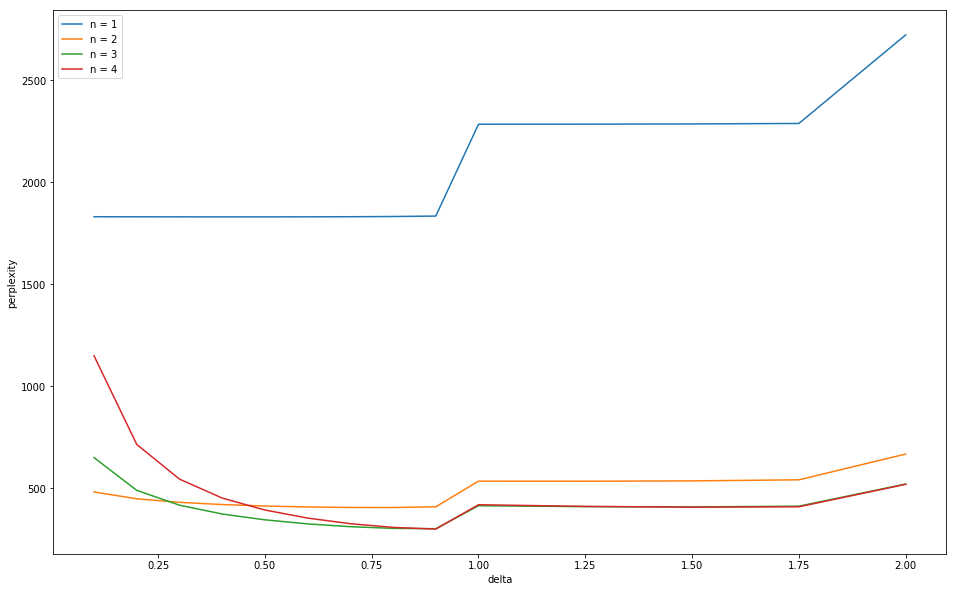

In [178]:
plt.figure(figsize=(16, 10))
for n in range(1, 5):
    plt.plot(*(np.array(res[n]).T), label='n = {}'.format(n))
    plt.ylabel('perplexity')
    plt.xlabel('delta')
    plt.legend()

Видно, что наилучшие параметры $n = 3$, $\delta = 0.9$